# $Q$-learning on linear quadratic problem
In this notebook, we run the $Q$-learning algorithm on a linear quadratic (LQ) control problem. 
* [You can read about the linear quadratic problem here](linear_quadratic.ipynb)
* [You can read about $Q$-learning here.](q_notebook.ipynb)
* [You can see the pure code for $Q$-learning on the LQ here.](./lq/q_on_lq.py)

## Summary of the algorithm
Since the dynamical system is linear and the value function is quadratic, we consider a quadratic $Q$ function as follows

\begin{align*}
Q(s,a) =\begin{bmatrix}
s^T & a^T
\end{bmatrix}\begin{bmatrix}
g_{ss} & g_{sa}\\
g_{sa}^T & g_{aa} \end{bmatrix}\begin{bmatrix}
s\\a \end{bmatrix}= z^T G z
\end{align*}
where $z=\begin{bmatrix}
s^T & a^T
\end{bmatrix}^T $ and $G= \begin{bmatrix}
g_{ss} & g_{sa}\\
g_{sa}^T & g_{aa} \end{bmatrix}$.

The policy is given by 

\begin{align*}
\pi = -g_{aa}^{-1}g_{sa}^T \: s = K s
\end{align*}

We start right away by selecting a stabilizing policy (or equivalently initializing the $Q$-function such that the resulting policy is stabilizing). Selecting a stabilizing policy is crucial for convergence of Least Square Temporal Difference (LSTD) algorithms. In each iteration of the algorithm, we do the following

* i. We rollout the environment using the current policy to compute the average cost.
* ii. We rollout the environment to collect data for $Q$ learning by following these steps:
    * ii.a. We initialize empty histories for `states=[]`, `actions=[]`, `costs=[]`, `next_states=[]`, `dones=[]`.
    * ii.b. We observe the `state` $s$ and select the `action` $a$ according to
    
    `a = K @ state + stddev * np.random.randn(n_a).`
    
    * ii.c. We derive the environment using $a$ and observe the `cost` $c$ and the next state $s^{\prime}$.
    * ii.d. We add $s,\:a,\:c,\:s^{\prime}$ to the history batch `states`, `actions`, `costs`, `next_states`, `dones`.
    * ii.e. We continue from i.b. until the episode ends.
* iii. We estimate the quadraic kernel of the $Q$ function. Let $vecv(v)=[v_1^2,\: 2v_1 v_2,...,2v_1 v_n,\:v_2^2,...,\: 2v_2 v_n,\: ... ,v_n^2]^{T}$. The LSTD estimation of $G$ is given by

\begin{align*}		
vecs(G)= ( \frac{1}{T}\sum_{t=1}^{T} \Psi_t (\Psi_t- \Psi_{t+1}) ^T )^{-1} ( \frac{1}{T}\sum_{t=1}^{T} \Psi_t (c_t - \lambda) ), 
\end{align*}

where $c_t$ is the running cost, $\lambda$ is the average cost obtained in step i., $z_k = [s_k^T,\:a_k^T]^T$,   $\Psi_t=vecv(z_k)$ and $T$ is the rollout length. Note that, we have considered minimizing the average cost setting in the $Q$ learning. It means that $\gamma =1$ and $r_t = c_t - \lambda$.

* iv. When the $Q$-function is estimated, the policy $\pi$ is obtained by mathematical minimization of the function $Q(s,a)$. For the linear quadrtaic problem, the policy is given by
\begin{align*}
\pi = -g_{aa}^{-1}g_{sa}^T \: s = K \: s.
\end{align*}


## Running on google colab
If you want to run on google colab, go ahead and run the following cell. If you want to run on your computer, skip this cell and start from Importing libraries.

In [1]:
!git clone https://github.com/FarnazAdib/Crash_course_on_RL.git
%cd Crash_course_on_RL
!pip install .

Cloning into 'Crash_course_on_RL'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 168 (delta 95), reused 148 (delta 75), pack-reused 0
Receiving objects: 100% (168/168), 357.83 KiB | 8.73 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/Crash_course_on_RL
Processing /content/Crash_course_on_RL
  Created wheel for Reinforcement-Learning-for-Control: filename=Reinforcement_Learning_for_Control-0.0.1-cp36-none-any.whl size=3832 sha256=342234043714e9cb09f10cd6f56b6da6d5da9aff20a3bb84ac17c64ca2fc5f56
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3bkrzhj/wheels/9b/1d/4f/f6799e86f243362b1f3fb259778269457c7c763ccf94aab885
Successfully built Reinforcement-Learning-for-Control


## Importing libraries
We start coding by importing the required libraries. If you get an error, you have possibly forgotten to change the kernel. See [Prepare a virtual environment](Preparation.ipynb).

In [2]:
import numpy as np
from lq.model_estimation import MODEL
from lq.dynamics import Linear_Quadratic
from lq.storing_matrices import Storing_Mat, Storing_Mat_opt
from lq.pltlib import PLTLIB
import scipy.linalg as LA
from lq.policies import LinK
from lq.funlib import GtoP, vecv, SquareMat, inst_variable

## Making the environment
We select the random seed and make the linear quadratic problem. We also initialize the controller gain `K0`.


In [3]:
rand_seed = 1
np.random.seed(rand_seed)
A = np.array([[1.0, 1.0], [0.0, 1.0]])
B = np.array([[0.0], [1.0]])
x0 = np.array([[-1.0, 0.0]], dtype='float32')
ep = 0.1
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])

Mysys = Linear_Quadratic(A, B, Q, R, x0, ep)
_, K0 = Mysys.lqr_gain(200*Mysys.Q, Mysys.R)

## Making the $Q$-learning agent
We define the $Q$-learning class here.

In [4]:
class Q_learning:
    def __init__(self, sysdyn:Linear_Quadratic):
        # self.rand_seed = 1
        # np.random.seed(self.rand_seed)
        self.dyn = sysdyn
        self.n, self.m = self.dyn.B.shape
        self.n_phi = int((self.n + self.m) * (self.n + self.m + 1) / 2)
        self.P = np.zeros((self.n, self.n))

    def ql(self, K0, N, T, explore_mag=1.0):
        '''
        Q learning loop to iterate over policy iteration and policy improvement
        :param K0: The initial policy gain
        :param N: Number of iterations
        :param T: Trajectory length
        :param explore_mag: The amount of randomness in Q learning
        :return: The kernel of the value function P and the controller gain K
        '''
        self.K = K0
        for k in range(N):

            # If the controller is stable, do an iteration
            if self.dyn.is_stable(self.K):

                # Policy evaluaion
                G = self.q_evaluation(T, explore_mag)

                # Policy improvement
                self.K = self.q_improvement(G)
                P = GtoP(G, self.K)

            # If the controller is not stable, return some unstable values for P and K
            else:
                P, self.K = self.unstable_P_and_K()

        return P, self.K

    def q_evaluation(self, T, explore_mag):
        # creating the linear policy and turning sampling on
        Lin_gain = LinK(self.K)
        Lin_gain.make_sampling_on(explore_mag)

        # Do one rollout to compute the average cost
        _, _, r, _ = self.dyn.one_rollout(Lin_gain.lin_policy, T)
        Lam = np.sum(r)/T

        # Do one rollout to save data for Q learning
        states, actions, costs, next_states = self.dyn.one_rollout(Lin_gain.sample_lin_policy, T)

        # Making the state z and the next state z
        z = np.concatenate((states, actions), axis=1)
        next_z = np.concatenate((next_states, Lin_gain.lin_policy(next_states)), axis=1)

        # estimating the Q parameter using instrumental variable
        x_iv = vecv(z) - vecv(next_z)
        y_iv = costs - Lam
        z_iv = vecv(z)
        q_vec = inst_variable(x_iv, y_iv, z_iv)
        return SquareMat(q_vec, self.n+self.m)

    def q_improvement(self, G):
        return - LA.inv(G[self.dyn.n:, self.dyn.n:]) @ G[self.dyn.n:, 0:self.dyn.n]

    def unstable_P_and_K(self):
        return np.zeros((self.n, self.n)), np.zeros((self.m, self.n))


We have built the $Q$-learning class. It remains to build an object from this class. You can change the following hyper parameters if you like

* `T`: The trajectory length
* `n_iteration`: Number of iterations
* `n_batch`: Number of batches in each iteration of the optimization
* `n_monte_carlo`: Number of monte carlo to analyze the performance of the PG
* `explore_mag`: The amount of randomness in Q learning

It would be interesting to compare the performance of the $Q$-learning algorithm with a model-building approach. In a model-building approach, we estimate $(A, B)$ by using the collected data and solve the model-based Algebraic Riccati Equation assuming that the estimated matrices are the true matrices. We have built the model-learning class and below, we build an object of this class.

In [5]:
My_q_learning = Q_learning(Mysys)
My_model_learning = MODEL(Mysys)
T = np.array([0, 100])
n_iteration = 5
n_monte_carlo = 10

We initialize some matrices to store the results of the algorithms for different numbers of iterations and monte carlo evaluation.

In [6]:
OPT = Storing_Mat_opt("Optimal Solution", Mysys, n_monte_carlo, len(T))
Q = Storing_Mat("Q-learning", Mysys, K0, n_monte_carlo, len(T))
MODEL_LEARNING = Storing_Mat("Model-learning", Mysys, K0, n_monte_carlo, len(T))
Methods = [Q, MODEL_LEARNING]

## Start learning
Now, we evaluate the performance of $Q$-learning on the LQ problem. The algorithm is run for the trajectory length given in the `T` array. We also repeat the simulation for `n_monte_carlo` times and report the mean value for the parameters and errors to reduce the effect of randomness on our learning. In practice, you need to use a larger `n_monte_carlo ` than 10. We have chosen 10 to get the results fast. The $Q$-learning algorithm returns the estimated gain $\bar{K}$. In the second loop below, we compute the finite average cost, infinite average cost, and the error from the exact $K_{opt}$.

In [7]:
for t in range(1, len(T)):
    for trial in range(n_monte_carlo):
        print('Rollout Length: %d, MC trial: %d' % (T[t], trial))

        print('Q learning')
        Q.P[:, :, trial, t], Q.K[:, :, trial, t] = My_q_learning.ql(K0, n_iteration, T[t])

        print('Model learning')
        MODEL_LEARNING.P[:, :, trial, t], MODEL_LEARNING.K[:, :, trial, t] = \
            My_model_learning.nominal_PK(K0, n_iteration, T[t])

for t in range(1, len(T)):
    for trial in range(n_monte_carlo):
        OPT.J_fin[trial, t] = Mysys.cost_finite_average_K(OPT.K, T[t])
        for meth in Methods:
            meth.J_inf[trial, t] = Mysys.cost_inf_K(meth.K[:, :, trial, t])
            meth.J_fin[trial, t] = Mysys.cost_finite_average_K(meth.K[:, :, trial, t], T[t])
            meth.Ke[trial, t] = Mysys.dist_from_optimal_K(meth.K[:, :, trial, t])
            _, meth.Pe[trial, t] = Mysys.P_and_Pe_associated_to_K(meth.K[:, :, trial, t])


Rollout Length: 100, MC trial: 0
Q learning
Model learning
Rollout Length: 100, MC trial: 1
Q learning
Model learning
Rollout Length: 100, MC trial: 2
Q learning
Model learning
Rollout Length: 100, MC trial: 3
Q learning
Model learning
Rollout Length: 100, MC trial: 4
Q learning
Model learning
Rollout Length: 100, MC trial: 5
Q learning
Model learning
Rollout Length: 100, MC trial: 6
Q learning
Model learning
Rollout Length: 100, MC trial: 7
Q learning
Model learning
Rollout Length: 100, MC trial: 8
Q learning
Model learning
Rollout Length: 100, MC trial: 9
Q learning
Model learning


## Results
We plot the result of the simulation here. The first figure shows the fraction of times the algorithm returns stable policies in all iterations. The second figure shows the error between the estimated gain and the optimal gain; $K_e =\frac{||\bar{K}-K_{opt}||}{||K_{opt}||}$. The third figure shows the error between the infinite average costs by the estimated controller gain and the optimal controller $K_e =\frac{||\bar{J}-J_{opt}||}{||J_{opt}||}$. In all three figures, the zero rollout length refers to the initiation of the algorithm. 

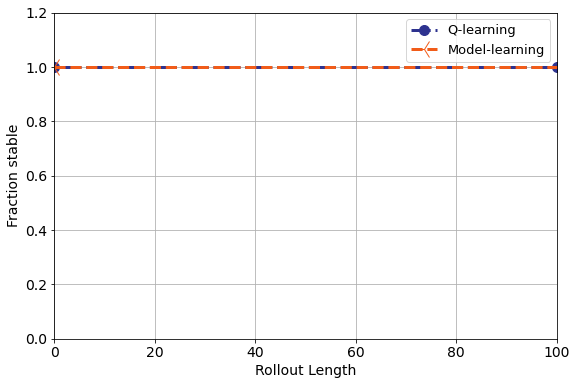

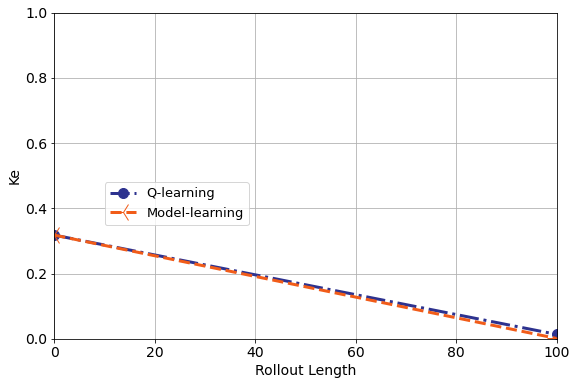

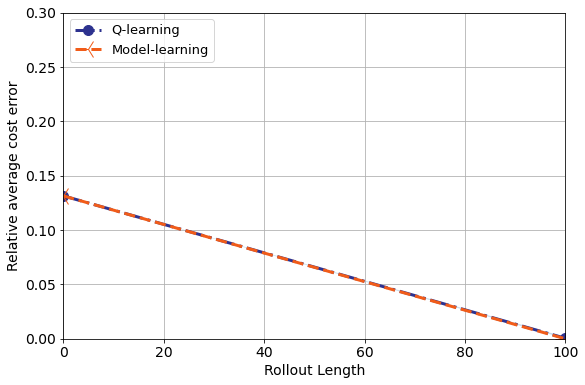

In [8]:
MyPlot = PLTLIB(OPT.J_inf)
J = [meth.J_inf for meth in Methods]
Lab = [meth.name for meth in Methods]
MyPlot.frac_stable(J, T, n_monte_carlo, Lab, 'Rollout Length')
MyPlot.est_e([meth.Ke for meth in Methods], T, Lab, 'Rollout Length', "Ke", 1)
MyPlot.relative_inf_cost(J, T, Lab, 'Rollout Length', uplim=0.3, zoomplt=False)

We print the estimated controller gain with the $Q$-learning and the model-building approach, and compare it with the analytical optimal solution. As you can see, they are pretty close.

In [9]:
print('\nThe optimal k \n', OPT.K)
for meth in Methods:
    print('\nMean of estimated K using', meth.name, '\n', np.mean(meth.K[:, :, :, -1], axis=2))

for meth in Methods:
    print('\nMedian of Ke using', meth.name, np.median(meth.Ke[:, -1]))


The optimal k 
 [[-0.42208244 -1.24392885]]

Mean of estimated K using Q-learning 
 [[-0.42277216 -1.25160717]]

Mean of estimated K using Model-learning 
 [[-0.42192511 -1.24353733]]

Median of Ke using Q-learning 0.01357432413689584

Median of Ke using Model-learning 0.0011399673750473473


The median of $K_e$ will be around $1\%$. [It has been shown that as the trajectory length encreases, the estimated controller gain converges to the optimal controller.](http://proceedings.mlr.press/v99/tu19a/tu19a.pdf) Moreover, observe that even the simplest model-learning approach performs super good!